In [1]:
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,12)
import seaborn as sns

In [2]:
import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import CellAssign

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('12', '17'), color_map='gist_earth')

In [4]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',

'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#000000',
 'Unknown':'#000000'}

In [5]:
markers_dict = {'Parietal Epithelial Cell': ['CLDN1', 'VCAM1', 'CFH', 'RBFOX1', 'ALDH1A2'],
                 'Proximal Tubule Cell': ['LRP2', 'CUBN', 'SLC13A1','SLC5A12','SLC22A7','SLC22A6'],
                 'Thin Limb Cell': ['CRYAB', 'TACSTD2', 'SLC44A5', 'KLRG2', 'COL26A1', 'BOC'],
                 'Thick Ascending Limb Cell': ['CASR', 'SLC12A1', 'UMOD'],
                 'Distal Convoluted Tubule Cell': ['SLC12A3','CNNM2', 'FGF13', 'KLHL3', 'LHX1', 'TRPM6'],
                 'Connecting Tubule': ['SLC8A1', 'SCN2A', 'HSD11B2', 'CALB1'],
                 'Principal Cell': ['GATA3', 'AQP2', 'AQP3'],
                 'Endothelial Cell': ['CD34', 'PECAM1', 'PTPRB', 'MEIS2', 'FLT1', 'EMCN'],
                 'Mesenglial':['PIP5K1B','ROBO1','DAAM2', 'PHTF2', 'POSTN'],
                 'Vascular Smooth Muscle Cell _ Pericyte': ['NTRK3','MYH11'],
                 'Fibroblast': ['COL1A1', 'COL1A2', 'C7', 'NEGR1', 'FBLN5', 'DCN', 'CDH11'],
                 'Immune Cells': ['PTPRC','PRKCB','ARHGAP15','MS4A1','CD96','CD14','S100A9','MS4A2','CD163'],
                 # 'Schwann Cell _ Neural': ['CDH19', 'NRXN1', 'GINS3'],
                 'Podocyte': ['PTPRQ', 'WT1', 'NPHS2','NPSH1', 'PODXL'],
                 'Adaptative Proximal Tubule Cell': ['ITGB8', 'DCDC2', 'TPM1','HAVCR1','KIF26B','ACSM3','DLGAP1','CDH6'],
                 'Intercalated Cell A': ['SLC4A1', 'SLC26A7', 'CLNK', ' TMEM213'],
                 'Intercalated Cell B': ['SLC4A9', 'SLC35F3', 'SLC26A4', 'INSRR','TLDC2']}

In [6]:
adata = sc.read('objects/Deepscore_markers.h5ad')

In [7]:
adata_rna = sc.read('../../../external_references/local.h5ad')
adata_rna.var['ENSG'] = adata_rna.var.index.copy()
adata_rna.var.index = adata_rna.var['feature_name'].copy()
adata_rna.layers['counts'] = adata_rna.raw.X.todense().copy()

In [8]:
adata_rna

AnnData object with n_obs × n_vars = 19985 × 33234
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_SCT', 'nFeature_SCT', 'percent.mt', 'percent.rpl', 'percent.rps', 'seurat_clusters', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'ENSG'
    uns: 'default_embedding', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [9]:
adata.X = adata.layers['counts'].copy()

In [10]:
adata.obs['Label'] = 'Unknown'
adata_rna.obs['Label'] = adata_rna.obs['author_cell_type'].copy()

In [11]:
adata = adata.concatenate(adata_rna, join='inner', batch_categories=['RNA','External_reference'])
adata

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_m

AnnData object with n_obs × n_vars = 95303 × 3000
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore_external', 'Label', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_SCT', 'nFeature_SCT', 'percent.mt', 'percent.rpl', 'percent.rps', 'seurat_clusters', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'batch'
    var: 'feature_is_filtered-External_reference', 'feature_name-External_reference', 'feature_reference-External_refere

In [12]:

rcParams['figure.figsize'] = (12,12)

scvi.model.SCVI.setup_anndata(adata, batch_key='batch', labels_key="Label")

scvi_model = scvi.model.SCVI(adata, n_latent=30, n_layers=2)

scvi_model.train(100)

scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, "Unknown")


scanvi_model.train(25)


Epoch 6/25:  20%|█▌      | 5/25 [02:10<08:42, 26.15s/it, loss=1.72e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/25:  24%|█▉      | 6/25 [02:36<08:17, 26.19s/it, loss=1.74e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/25:  28%|██▏     | 7/25 [03:02<07:50, 26.15s/it, loss=1.74e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/25:  32%|██▌     | 8/25 [03:28<07:21, 25.99s/it, loss=1.77e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/25:  36%|██▌    | 9/25 [03:54<06:57, 26.07s/it, loss=1.73e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/25:  40%|██▍   | 10/25 [04:20<06:29, 25.95s/it, loss=1.78e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/25:  44%|██▋   | 11/25 [04:48<06:10, 26.47s/it, loss=1.71e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/25:  48%|██▉   | 12/25 [05:23<06:18, 29.13s/it, loss=1.74e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/25:  52%|███   | 13/25 [05:49<05:39, 28.25s/it, loss=1.74e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/25:  56%|███▎  | 14/25 [06:09<04:41, 25.62s/it, loss=1.72e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/25:  60%|███▌  | 15/25 [06:30<04:05, 24.50s/it, loss=1.75e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/25:  64%|███▊  | 16/25 [06:52<03:31, 23.48s/it, loss=1.73e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/25:  68%|████  | 17/25 [07:11<02:57, 22.16s/it, loss=1.74e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/25:  72%|████▎ | 18/25 [07:30<02:29, 21.40s/it, loss=1.72e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/25:  76%|████▌ | 19/25 [07:49<02:04, 20.73s/it, loss=1.73e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/25:  80%|████▊ | 20/25 [08:07<01:38, 19.69s/it, loss=1.72e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/25:  84%|█████ | 21/25 [08:24<01:15, 18.86s/it, loss=1.75e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/25:  88%|█████▎| 22/25 [08:41<00:54, 18.30s/it, loss=1.77e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/25:  92%|█████▌| 23/25 [08:57<00:35, 17.81s/it, loss=1.73e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/25:  96%|█████▊| 24/25 [09:14<00:17, 17.61s/it, loss=1.72e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/25: 100%|██████| 25/25 [09:31<00:00, 17.37s/it, loss=1.73e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████| 25/25 [09:31<00:00, 22.87s/it, loss=1.73e+03, v_num=1]


In [42]:
scanvi_model.train(5)

INFO     Training for 5 epochs.                                                              


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/5:  20%|██        | 1/5 [00:15<01:00, 15.20s/it, loss=1.74e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/5:  40%|████      | 2/5 [00:30<00:45, 15.17s/it, loss=1.72e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/5:  60%|██████    | 3/5 [00:45<00:30, 15.14s/it, loss=1.74e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/5:  80%|████████  | 4/5 [01:00<00:15, 15.13s/it, loss=1.71e+03, v_num=1]

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/5: 100%|██████████| 5/5 [01:15<00:00, 15.01s/it, loss=1.74e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:15<00:00, 15.07s/it, loss=1.74e+03, v_num=1]


In [43]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [14]:
sc.pp.neighbors(adata, use_rep="X_scANVI")

In [15]:
sc.tl.umap(adata, spread = 2, min_dist = 0.7)

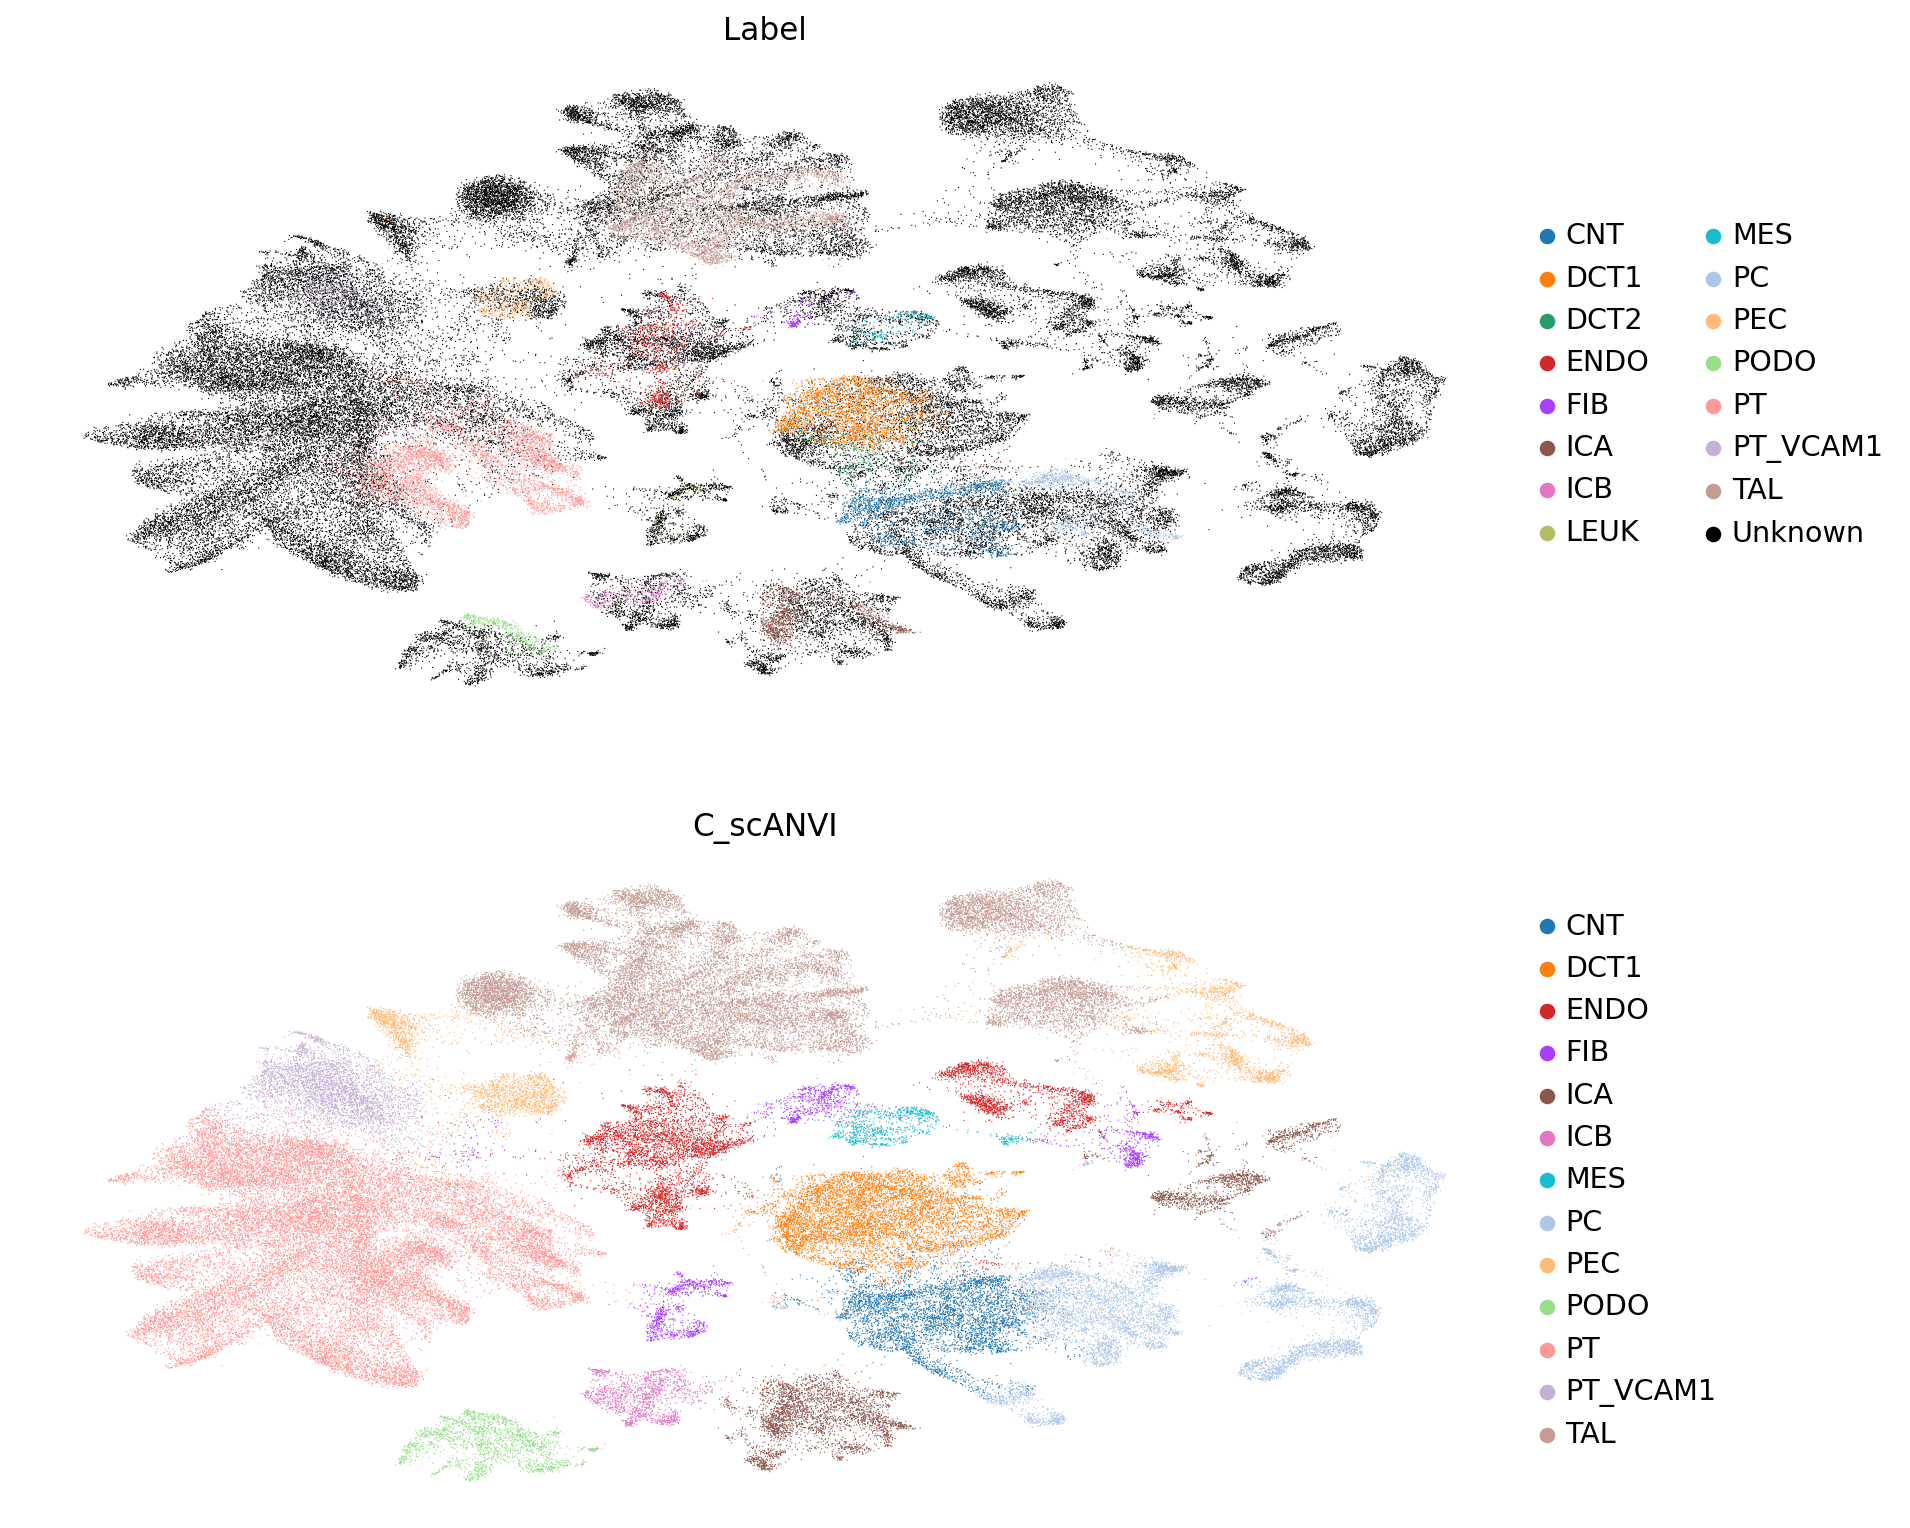

In [44]:
fig, ax = plt.subplots(2, 1, sharey=True)
sc.pl.umap(adata, color=["Label"], ax = ax[0], frameon=False, show=False, palette = palette)
sc.pl.umap(adata, color=["C_scANVI"], ax = ax[1], frameon=False, palette =palette)


/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


<AxesSubplot:title={'center':'Label'}, xlabel='UMAP1', ylabel='UMAP2'>

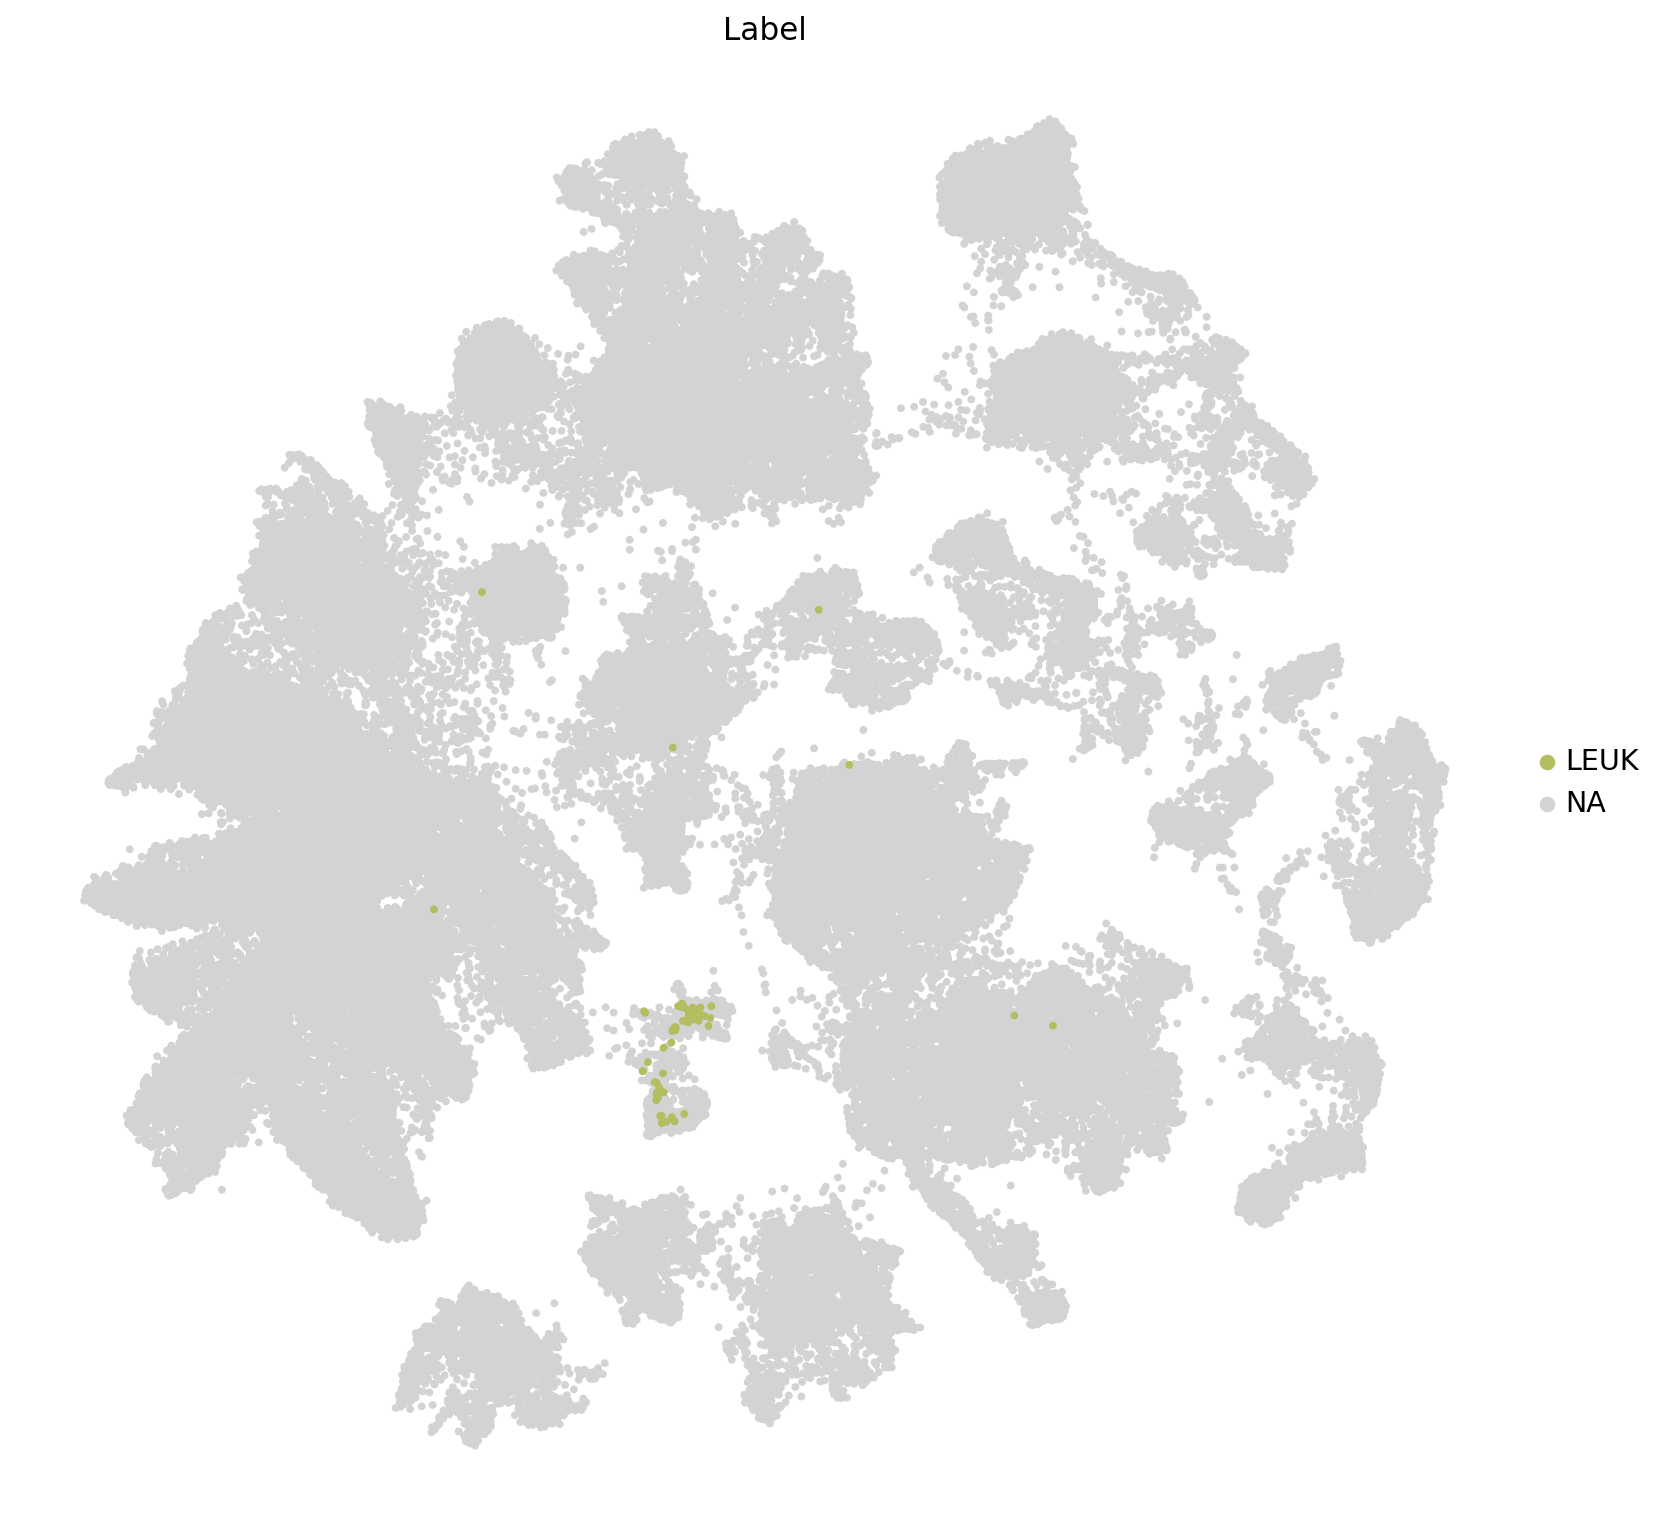

In [41]:
sc.pl.umap(adata, color=["Label"],  frameon=False, show=False, palette = palette, groups=['LEUK'], size = 50)


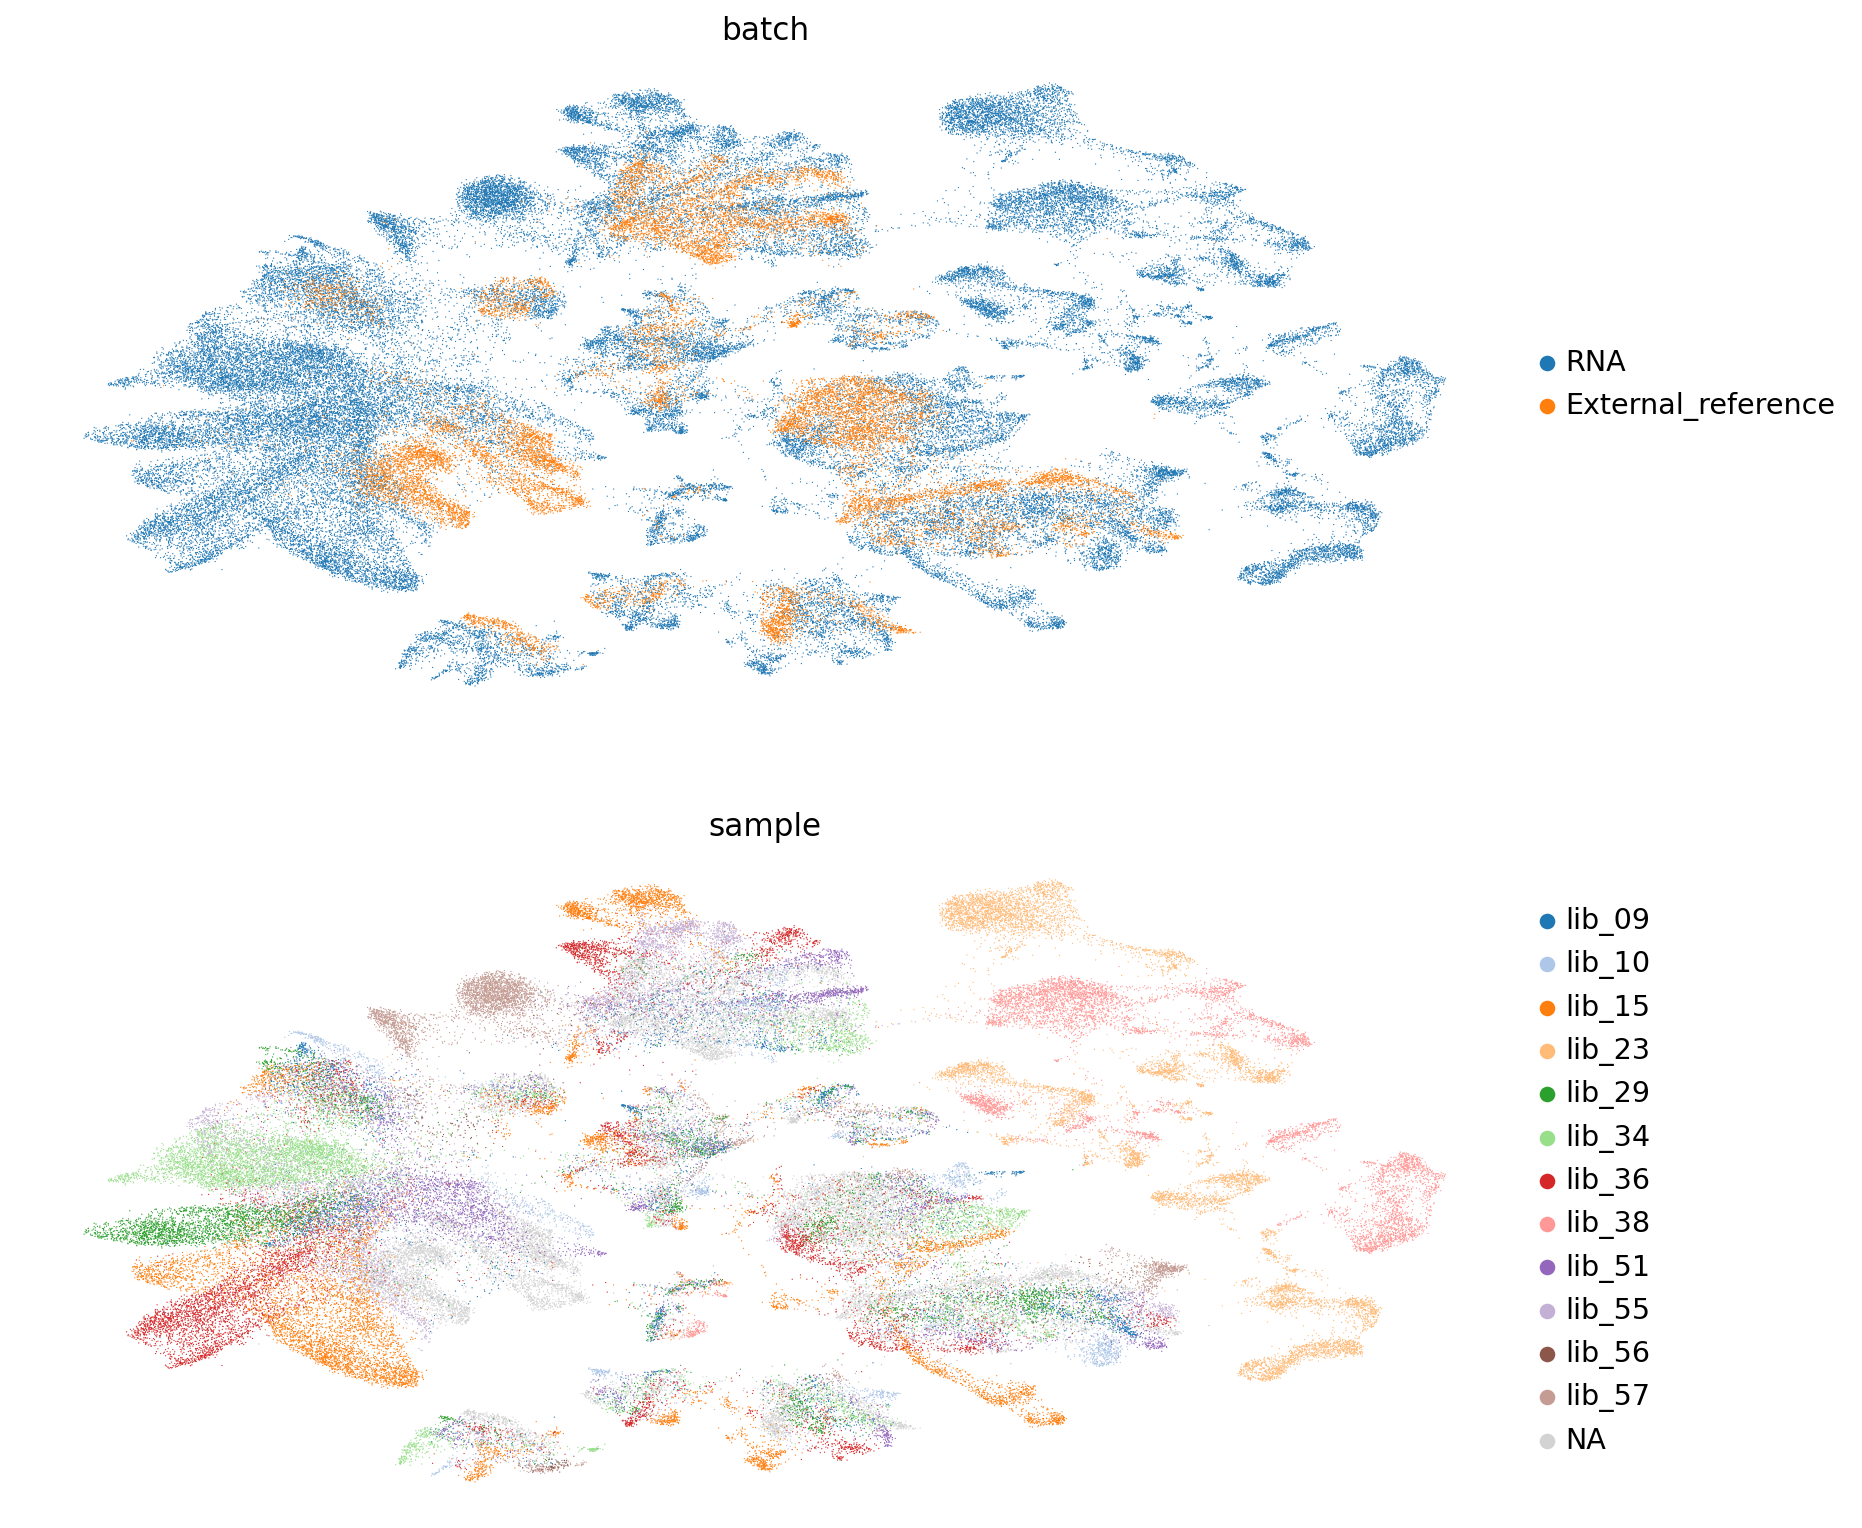

In [29]:
fig, ax = plt.subplots(2, 1, sharey=True)
sc.pl.umap(adata, color=["batch"], ax = ax[0], frameon=False, show=False)
sc.pl.umap(adata, color=["sample"], ax = ax[1], frameon=False, palette =  sns.color_palette("tab20",len(adata.obs['Label'].unique())))


In [30]:
adata

AnnData object with n_obs × n_vars = 95303 × 3000
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore_external', 'Label', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_SCT', 'nFeature_SCT', 'percent.mt', 'percent.rpl', 'percent.rps', 'seurat_clusters', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'feature_is_filtered-External_reference', 'feature_name-External_reference', 'feature_r

In [31]:
adata_rna.obs['author_cell_type'].unique().tolist()

['PC',
 'PT',
 'TAL',
 'DCT2',
 'DCT1',
 'ICA',
 'ICB',
 'PEC',
 'CNT',
 'ENDO',
 'MES',
 'PODO',
 'PT_VCAM1',
 'LEUK',
 'FIB']

In [32]:
adata.obs['C_scANVI'].unique().tolist()

['PC',
 'PT',
 'PEC',
 'TAL',
 'FIB',
 'DCT1',
 'ICB',
 'ENDO',
 'ICA',
 'PODO',
 'PT_VCAM1',
 'MES',
 'CNT']

In [33]:
# adata.var = pd.DataFrame(index = adata.var.index)
# adata.obs = adata.obs[['sample','Label','author_cell_type',]]

In [45]:
adata.write('objects/scANVI_merged_label_transfer_ext_ref_DS_markers.h5ad', compression = 'gzip')

In [ ]:
rna = adata[adata.obs['batch'].isin(['RNA'])]

In [ ]:
rna

View of AnnData object with n_obs × n_vars = 75318 × 3000
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore_external', 'Label', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_SCT', 'nFeature_SCT', 'percent.mt', 'percent.rpl', 'percent.rps', 'seurat_clusters', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'feature_is_filtered-External_reference', 'feature_name-External_reference', 'f

In [ ]:
rna.write('objects/scANVI_label_transfer_ext_ref_DS_markers.h5ad', compression = 'gzip')